# 06. Final Evaluation & Comparison

## 목표
- 모든 실험 전략의 성능 종합 비교
- 최종 제출 전략 결정
- 프로젝트 인사이트 정리

## 비교 대상
1. **Baseline**: 단순 CatBoost 모델
2. **SMOTE**: 클래스 불균형 해소 (합성 샘플 생성)
3. **Cross-Validation**: 5-Fold CV 평균/가중 예측
4. **Feature Selection**: 중요 피처만 사용
5. **Stacking**: 다중 모델 앙상블

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


## 1. 실험 결과 로드

In [2]:
# 결과 파일 경로
output_dir = Path('../output')

# 사용 가능한 결과 파일 확인
result_files = {
    'baseline': output_dir / 'baseline_results.csv',
    'imbalance': output_dir / 'imbalance_results.csv',
    'cv_metrics': output_dir / 'cv_fold_metrics.csv',
    'feature_selection': output_dir / 'feature_selection_results.csv',
    'stacking': output_dir / 'stacking_summary.csv'
}

print("📂 결과 파일 확인:")
available_results = {}
for name, path in result_files.items():
    if path.exists():
        available_results[name] = pd.read_csv(path)
        print(f"  ✅ {name}: {path.name}")
    else:
        print(f"  ❌ {name}: 파일 없음")

📂 결과 파일 확인:
  ✅ baseline: baseline_results.csv
  ✅ imbalance: imbalance_results.csv
  ✅ cv_metrics: cv_fold_metrics.csv
  ✅ feature_selection: feature_selection_results.csv
  ✅ stacking: stacking_summary.csv


## 2. 성능 지표 종합

In [9]:
# 전략별 성능 요약 생성
performance_summary = []

# 2-1. Baseline
if 'baseline' in available_results:
    baseline = available_results['baseline']
    if 'roc_auc' in baseline.columns:
        performance_summary.append({
            'Strategy': 'Baseline (CatBoost)',
            'ROC_AUC': baseline['roc_auc'].iloc[0] if len(baseline) > 0 else None,
            'Description': '단순 CatBoost, class_weight=Balanced',
            'Category': 'Single Model'
        })

# 2-2. SMOTE
if 'imbalance' in available_results:
    imbalance = available_results['imbalance']
    if 'roc_auc' in imbalance.columns:
        performance_summary.append({
            'Strategy': 'SMOTE (Oversampling)',
            'ROC_AUC': imbalance['roc_auc'].iloc[0] if len(imbalance) > 0 else None,
            'Description': 'SMOTE로 소수 클래스 증강',
            'Category': 'Single Model'
        })

# 2-3. Cross-Validation
if 'cv_metrics' in available_results:
    cv_metrics = available_results['cv_metrics']
    if 'auc' in cv_metrics.columns:
        performance_summary.append({
            'Strategy': 'Cross-Validation (5-Fold)',
            'ROC_AUC': cv_metrics['auc'].mean(),
            'Description': f"5-Fold CV 평균 (std={cv_metrics['auc'].std():.4f})",
            'Category': 'Cross-Validation'
        })

# 2-4. Feature Selection
if 'feature_selection' in available_results:
    feat_sel = available_results['feature_selection']
    if 'mean_auc' in feat_sel.columns:
        best_idx = feat_sel['mean_auc'].idxmax()
        performance_summary.append({
            'Strategy': f"Feature Selection (Top {feat_sel.loc[best_idx, 'n_features']:.0f})",
            'ROC_AUC': feat_sel.loc[best_idx, 'mean_auc'],
            'Description': f"중요 Feature만 사용 (누적 중요도 {feat_sel.loc[best_idx, 'cumulative_importance']:.2%})",
            'Category': 'Feature Engineering'
        })

# 2-5. Stacking
if 'stacking' in available_results:
    stacking = available_results['stacking']
    if 'OOF_AUC' in stacking.columns:
        stacking_auc = stacking[stacking['Component'].str.contains('Stacking', na=False)]['OOF_AUC'].iloc[0]
        performance_summary.append({
            'Strategy': 'Stacking Ensemble',
            'ROC_AUC': stacking_auc,
            'Description': 'CatBoost + LightGBM + XGBoost + LogisticRegression',
            'Category': 'Ensemble'
        })

# DataFrame 생성
performance_df = pd.DataFrame(performance_summary).sort_values('ROC_AUC', ascending=False)

print(f"\n{'='*80}")
print("전체 실험 성능 비교 (ROC AUC 기준)")
print(f"{'='*80}")
display(performance_df)

# 최고 성능 전략
if len(performance_df) > 0:
    best_strategy = performance_df.iloc[0]
    print(f"\n🏆 최고 성능 전략:")
    print(f"  전략: {best_strategy['Strategy']}")
    print(f"  ROC AUC: {best_strategy['ROC_AUC']:.4f}")
    print(f"  설명: {best_strategy['Description']}")


전체 실험 성능 비교 (ROC AUC 기준)


,Strategy,ROC_AUC,Description,Category
3,Feature Selection (Top 100),0.637835,중요 Feature만 사용 (누적 중요도 95.08%),Feature Engineering
2,Cross-Validation (5-Fold),0.637415,5-Fold CV 평균 (std=0.0035),Cross-Validation
0,Baseline (CatBoost),0.636890,"단순 CatBoost, class_weight=Balanced",Single Model
1,SMOTE (Oversampling),0.607768,SMOTE로 소수 클래스 증강,Single Model



🏆 최고 성능 전략:
  전략: Feature Selection (Top 100)
  ROC AUC: 0.6378
  설명: 중요 Feature만 사용 (누적 중요도 95.08%)


## 3. 제출 파일 비교

In [10]:
# 제출 파일 예측 분포 비교
if submissions:
    print(f"\n📊 제출 파일 예측 통계:")
    submission_stats = []
    
    for name, df in submissions.items():
        if 'Label' in df.columns:
            preds = df['Label']
            submission_stats.append({
                'Submission': name,
                'Mean': preds.mean(),
                'Std': preds.std(),
                'Min': preds.min(),
                'Q25': preds.quantile(0.25),
                'Median': preds.median(),
                'Q75': preds.quantile(0.75),
                'Max': preds.max(),
                'Positive_Rate': (preds > 0.5).mean()
            })
    
    if submission_stats:
        submission_stats_df = pd.DataFrame(submission_stats)
        display(submission_stats_df.round(4))


📊 제출 파일 예측 통계:


,Submission,Mean,Std,Min,Q25,Median,Q75,Max,Positive_Rate
0,Baseline,0.4893,0.1333,0.2181,0.4302,0.5281,0.5941,0.6085,0.6
1,CV Mean,0.4895,0.1280,0.2252,0.4348,0.5461,0.5821,0.5929,0.6
2,CV Weighted,0.4895,0.1279,0.2255,0.4348,0.5461,0.5820,0.5929,0.6
3,Stacking,0.0313,0.0121,0.0110,0.0227,0.0360,0.0409,0.0428,0.0


## 4. 시각화 - 종합 비교

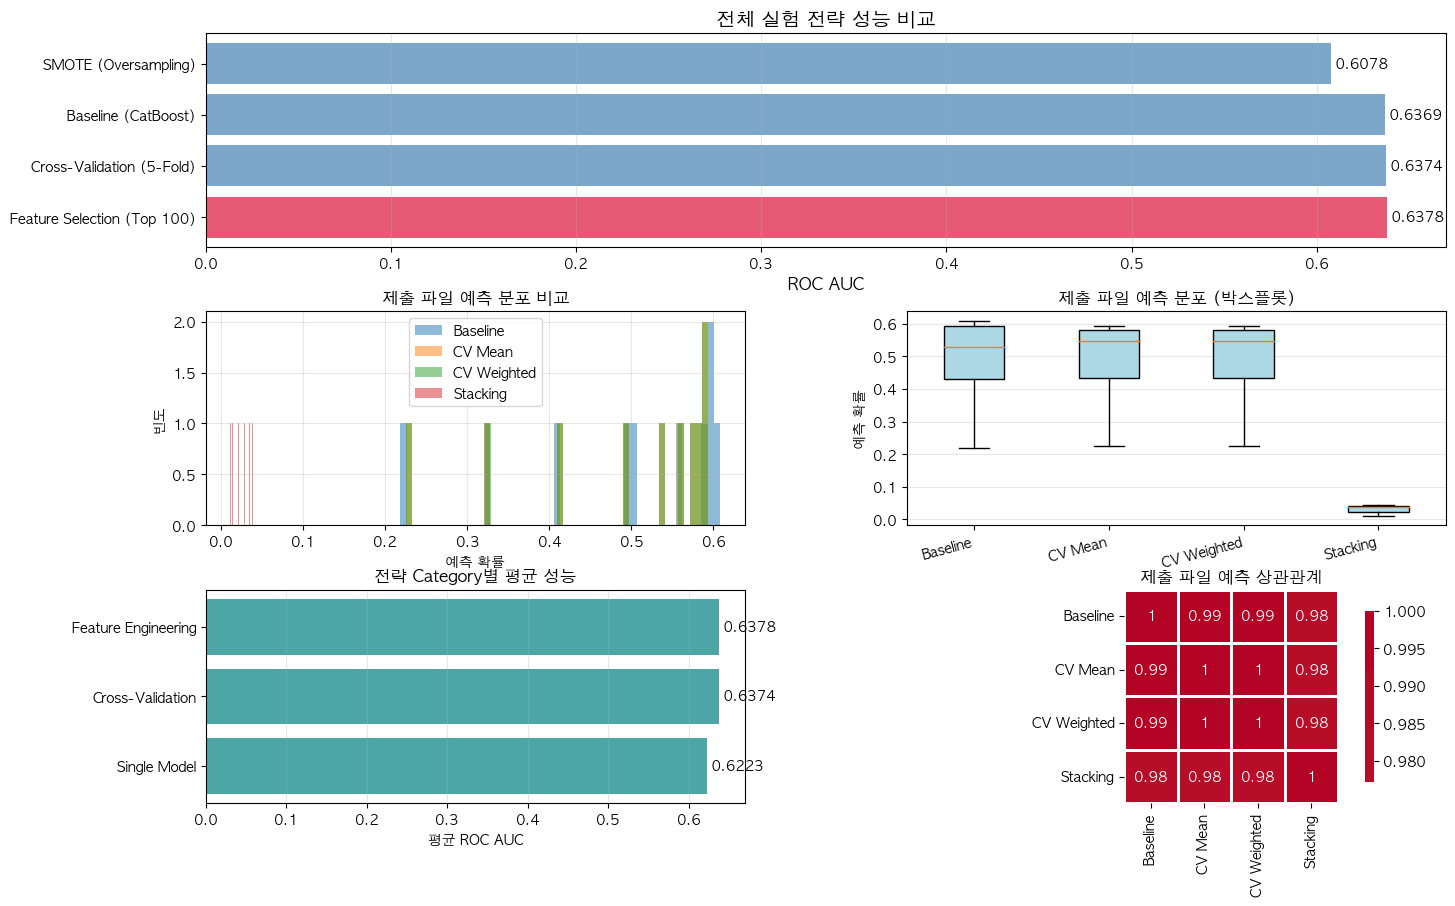


✅ 시각화 저장: ../output/figures/final_evaluation_comprehensive.png


In [11]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 4-1. 전략별 ROC AUC 비교
if len(performance_df) > 0:
    ax = fig.add_subplot(gs[0, :])
    colors = ['crimson' if i == 0 else 'steelblue' for i in range(len(performance_df))]
    bars = ax.barh(performance_df['Strategy'], performance_df['ROC_AUC'], color=colors, alpha=0.7)
    ax.set_xlabel('ROC AUC', fontsize=12)
    ax.set_title('전체 실험 전략 성능 비교', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    for i, (strategy, auc) in enumerate(zip(performance_df['Strategy'], performance_df['ROC_AUC'])):
        ax.text(auc, i, f' {auc:.4f}', va='center', fontsize=10, fontweight='bold')

# 4-2. 제출 파일 예측 분포
if submissions:
    ax = fig.add_subplot(gs[1, 0])
    for name, df in submissions.items():
        if 'Label' in df.columns:
            ax.hist(df['Label'], bins=50, alpha=0.5, label=name)
    ax.set_xlabel('예측 확률')
    ax.set_ylabel('빈도')
    ax.set_title('제출 파일 예측 분포 비교')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 4-3. 제출 파일 박스플롯
if submissions:
    ax = fig.add_subplot(gs[1, 1])
    data_to_plot = [df['Label'].values for df in submissions.values() if 'Label' in df.columns]
    labels_to_plot = [name for name, df in submissions.items() if 'Label' in df.columns]
    
    if data_to_plot:
        bp = ax.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        ax.set_ylabel('예측 확률')
        ax.set_title('제출 파일 예측 분포 (박스플롯)')
        ax.grid(True, alpha=0.3, axis='y')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 4-4. Category별 성능
if len(performance_df) > 0 and 'Category' in performance_df.columns:
    ax = fig.add_subplot(gs[2, 0])
    category_mean = performance_df.groupby('Category')['ROC_AUC'].mean().sort_values()
    ax.barh(category_mean.index, category_mean.values, color='teal', alpha=0.7)
    ax.set_xlabel('평균 ROC AUC')
    ax.set_title('전략 Category별 평균 성능')
    ax.grid(True, alpha=0.3, axis='x')
    
    for i, (cat, auc) in enumerate(zip(category_mean.index, category_mean.values)):
        ax.text(auc, i, f' {auc:.4f}', va='center', fontsize=10)

# 4-5. 제출 파일 상관관계
if len(submissions) >= 2:
    ax = fig.add_subplot(gs[2, 1])
    submission_df = pd.DataFrame({
        name: df['Label'].values 
        for name, df in submissions.items() 
        if 'Label' in df.columns
    })
    
    if len(submission_df.columns) >= 2:
        corr = submission_df.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, 
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
        ax.set_title('제출 파일 예측 상관관계')

plt.savefig(output_dir / 'figures' / 'final_evaluation_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 시각화 저장: ../output/figures/final_evaluation_comprehensive.png")

## 5. 학습 곡선 비교 (CV Folds)

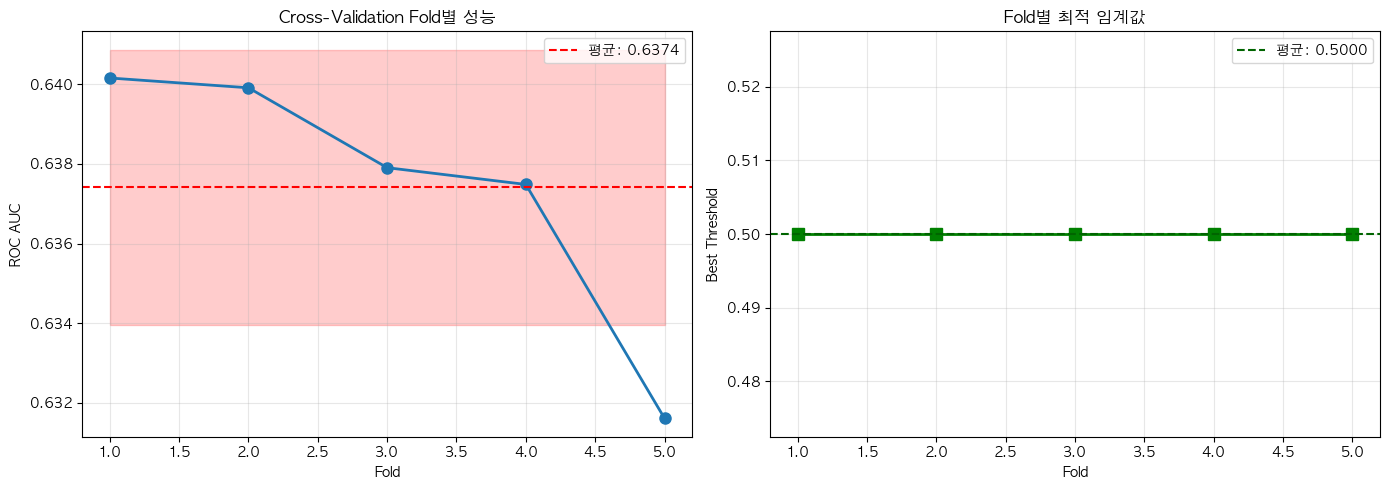


✅ 시각화 저장: ../output/figures/cv_stability_analysis.png

📈 CV 안정성 지표:
  변동 계수 (CV): 0.0054 (낮을수록 안정적)
  최대 편차: 0.0086


In [12]:
# CV Fold별 성능 변동성 분석
if 'cv_metrics' in available_results:
    cv_metrics = available_results['cv_metrics']
    
    if 'auc' in cv_metrics.columns and 'fold' in cv_metrics.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Fold별 AUC
        ax = axes[0]
        ax.plot(cv_metrics['fold'], cv_metrics['auc'], marker='o', linewidth=2, markersize=8)
        ax.axhline(cv_metrics['auc'].mean(), color='red', linestyle='--', 
                   label=f"평균: {cv_metrics['auc'].mean():.4f}")
        ax.fill_between(cv_metrics['fold'], 
                        cv_metrics['auc'].mean() - cv_metrics['auc'].std(),
                        cv_metrics['auc'].mean() + cv_metrics['auc'].std(),
                        alpha=0.2, color='red')
        ax.set_xlabel('Fold')
        ax.set_ylabel('ROC AUC')
        ax.set_title('Cross-Validation Fold별 성능')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Fold별 Threshold
        if 'best_threshold' in cv_metrics.columns:
            ax = axes[1]
            ax.plot(cv_metrics['fold'], cv_metrics['best_threshold'], 
                    marker='s', linewidth=2, markersize=8, color='green')
            ax.axhline(cv_metrics['best_threshold'].mean(), color='darkgreen', linestyle='--',
                       label=f"평균: {cv_metrics['best_threshold'].mean():.4f}")
            ax.set_xlabel('Fold')
            ax.set_ylabel('Best Threshold')
            ax.set_title('Fold별 최적 임계값')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(output_dir / 'figures' / 'cv_stability_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n✅ 시각화 저장: ../output/figures/cv_stability_analysis.png")
        
        # 안정성 지표
        cv_stability = cv_metrics['auc'].std() / cv_metrics['auc'].mean()
        print(f"\n📈 CV 안정성 지표:")
        print(f"  변동 계수 (CV): {cv_stability:.4f} (낮을수록 안정적)")
        print(f"  최대 편차: {cv_metrics['auc'].max() - cv_metrics['auc'].min():.4f}")